# 🏡 California Housing Price Prediction Project

---

### 📋 Project Objective:
This notebook is designed to **build a robust machine learning pipeline** for **predicting median house values** in California districts.  
The aim is to **explore**, **analyze**, **engineer new features**, and **train a powerful regression model** to achieve high prediction accuracy on unseen data.

---

### 🛠️ Key Features & Workflow:
- **Data Loading & Initial Exploration**:  
  We load the California housing dataset, explore basic statistics, and visualize distributions to understand feature behavior.
  
- **Feature Engineering**:  
  New features such as `Rooms_per_Household`, `Bedrooms_per_Room`, and `Income_per_Person` are created to enrich the dataset and enhance model performance.

- **Data Visualization**:  
  Correlation matrices, scatter plots, and heatmaps are used to identify important relationships between variables.

- **Stratified Sampling**:  
  Data is split into train/test sets using **income categories** to ensure representative distributions (important for fair evaluation).

- **Data Preprocessing Pipelines**:  
  Numerical features are scaled, missing values imputed, and categorical features one-hot encoded — all bundled inside a clean `Pipeline`.

- **Model Building**:  
  A powerful **XGBoost Regressor** is tuned using **Randomized Search CV** across hyperparameter grids for optimal performance.

- **Model Evaluation**:  
  The final model is evaluated using **MAPE** (Mean Absolute Percentage Error) and **MAE** (Mean Absolute Error) on the test set.

- **Model Saving**:  
  The trained model is saved using `joblib` for future deployment without retraining.

- **Interpretability**:  
  Feature importance plots and Actual vs Predicted scatter plots are used to interpret model behavior.

---

### 🚀 Highlights:
- Proper **train/test split based on stratification** (critical for real-world generalization).
- **Comprehensive feature engineering** that boosts predictive power.
- **End-to-end machine learning workflow**, from raw data to a ready-to-use model.

---


✅ **Let's dive into building a powerful housing price prediction model!**


In [283]:
# Importing all necessary libraries
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import joblib

In [284]:
# Load the California housing dataset
data = pd.read_csv("California_Houses.csv")
data.describe()  # Display summary statistics

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,2.064000e+04,2.064000e+04,20640.000000,20640.000000
mean,206855.816909,3.870671,28.639486,2635.763081,537.898014,1425.476744,499.539680,35.631861,-119.569704,40509.264883,2.694220e+05,3.981649e+05,349187.551219,386688.422291
std,115395.615874,1.899822,12.585558,2181.615252,421.247906,1132.462122,382.329753,2.135952,2.003532,49140.039160,2.477324e+05,2.894006e+05,217149.875026,250122.192316
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000,120.676447,4.205891e+02,4.849180e+02,569.448118,456.141313
25%,119600.000000,2.563400,18.000000,1447.750000,295.000000,787.000000,280.000000,33.930000,-121.800000,9079.756762,3.211125e+04,1.594264e+05,113119.928682,117395.477505
50%,179700.000000,3.534800,29.000000,2127.000000,435.000000,1166.000000,409.000000,34.260000,-118.490000,20522.019101,1.736675e+05,2.147398e+05,459758.877000,526546.661701
75%,264725.000000,4.743250,37.000000,3148.000000,647.000000,1725.000000,605.000000,37.710000,-118.010000,49830.414479,5.271562e+05,7.057954e+05,516946.490963,584552.007907
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000,333804.686371,1.018260e+06,1.196919e+06,836762.678210,903627.663298


In [285]:
# View the first 10 rows of the dataset
data.head(10)

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,452600.0,8.3252,41,880,129,322,126,37.88,-122.23,9263.040773,556529.158342,735501.806984,67432.517001,21250.213767
1,358500.0,8.3014,21,7099,1106,2401,1138,37.86,-122.22,10225.733072,554279.850069,733236.884360,65049.908574,20880.600400
2,352100.0,7.2574,52,1467,190,496,177,37.85,-122.24,8259.085109,554610.717069,733525.682937,64867.289833,18811.487450
3,341300.0,5.6431,52,1274,235,558,219,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
4,342200.0,3.8462,52,1627,280,565,259,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
5,269700.0,4.0368,52,919,213,413,193,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
6,299200.0,3.6591,52,2535,489,1094,514,37.84,-122.25,6843.020847,554364.406936,733249.808578,64315.991742,17538.209972
7,241400.0,3.1200,52,3104,687,1157,647,37.84,-122.25,6843.020847,554364.406936,733249.808578,64315.991742,17538.209972
8,226700.0,2.0804,42,2555,665,1206,595,37.84,-122.26,6363.948013,554949.749519,733820.824419,64751.463863,16744.406584
9,261100.0,3.6912,52,3549,707,1551,714,37.84,-122.25,6843.020847,554364.406936,733249.808578,64315.991742,17538.209972


In [286]:
# Check the shape of the dataset (rows, columns)
data.shape

(20640, 14)

In [287]:
# Check for missing values in each column
data.isnull().sum()

Median_House_Value          0
Median_Income               0
Median_Age                  0
Tot_Rooms                   0
Tot_Bedrooms                0
Population                  0
Households                  0
Latitude                    0
Longitude                   0
Distance_to_coast           0
Distance_to_LA              0
Distance_to_SanDiego        0
Distance_to_SanJose         0
Distance_to_SanFrancisco    0
dtype: int64

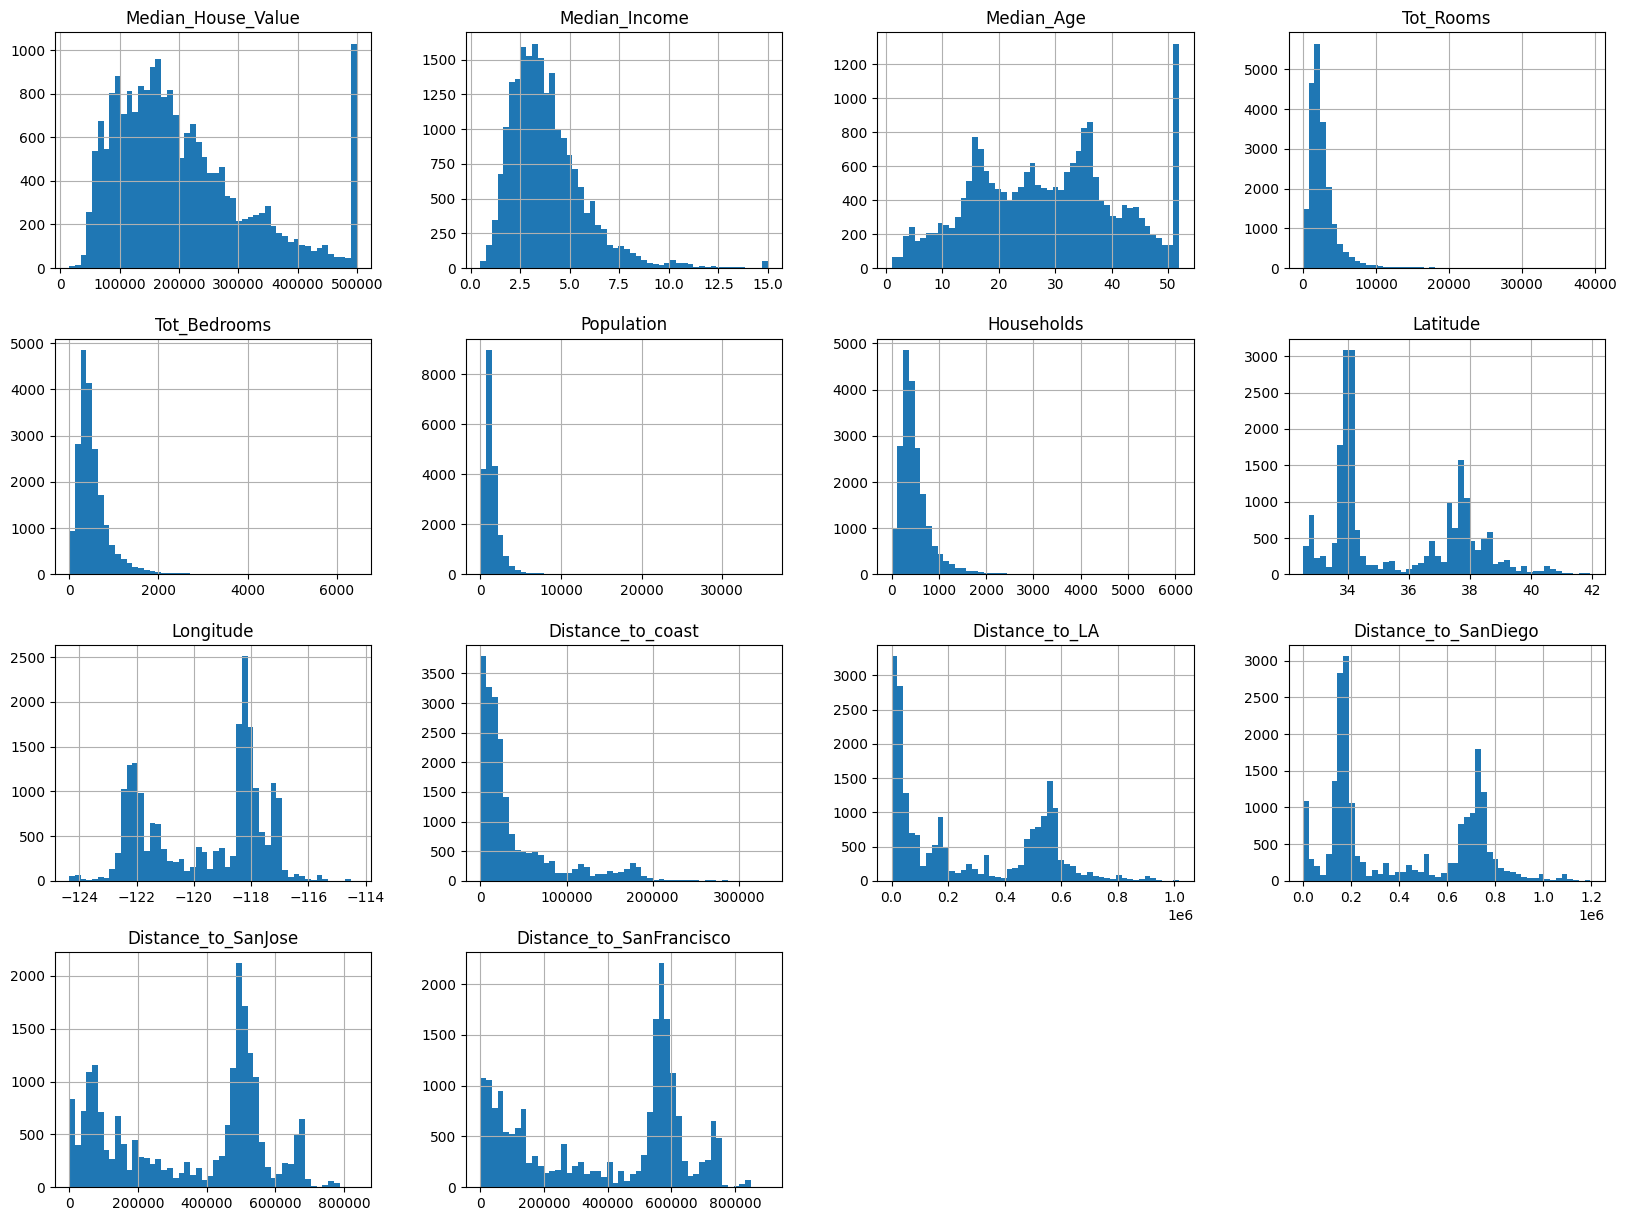

In [288]:
# Plot histograms for each numerical feature
data.hist(bins=50, figsize=(20, 15))
plt.show()

In [289]:
# Find the correlation of features with the target variable
correlation_matrix = data.corr()
correlation_matrix["Median_House_Value"].sort_values(ascending=False)

Median_House_Value          1.000000
Median_Income               0.688075
Tot_Rooms                   0.134153
Median_Age                  0.105623
Households                  0.065843
Tot_Bedrooms                0.050594
Population                 -0.024650
Distance_to_SanFrancisco   -0.030559
Distance_to_SanJose        -0.041590
Longitude                  -0.045967
Distance_to_SanDiego       -0.092510
Distance_to_LA             -0.130678
Latitude                   -0.144160
Distance_to_coast          -0.469350
Name: Median_House_Value, dtype: float64

In [290]:
# Feature Engineering: Create new features
data['Rooms_per_Household'] = data['Tot_Rooms'] / data['Households']
data['Bedrooms_per_Room'] = data['Tot_Bedrooms'] / data['Tot_Rooms']
data['Population_per_Household'] = data['Population'] / data['Households']
data["Income_per_Person"] = data["Median_Income"] / data["Population"]
data["Income_x_Households"] = data["Median_Income"] * data["Households"]
data["Bedrooms_x_Population"] = data["Tot_Bedrooms"] * data["Population"]

In [291]:
# Check correlations again after feature engineering
correlation_matrix = data.corr()
correlation_matrix["Median_House_Value"].sort_values(ascending=False)

Median_House_Value          1.000000
Median_Income               0.688075
Income_x_Households         0.352662
Rooms_per_Household         0.151948
Tot_Rooms                   0.134153
Income_per_Person           0.114455
Median_Age                  0.105623
Households                  0.065843
Tot_Bedrooms                0.050594
Bedrooms_x_Population       0.008239
Population_per_Household   -0.023737
Population                 -0.024650
Distance_to_SanFrancisco   -0.030559
Distance_to_SanJose        -0.041590
Longitude                  -0.045967
Distance_to_SanDiego       -0.092510
Distance_to_LA             -0.130678
Latitude                   -0.144160
Bedrooms_per_Room          -0.255624
Distance_to_coast          -0.469350
Name: Median_House_Value, dtype: float64

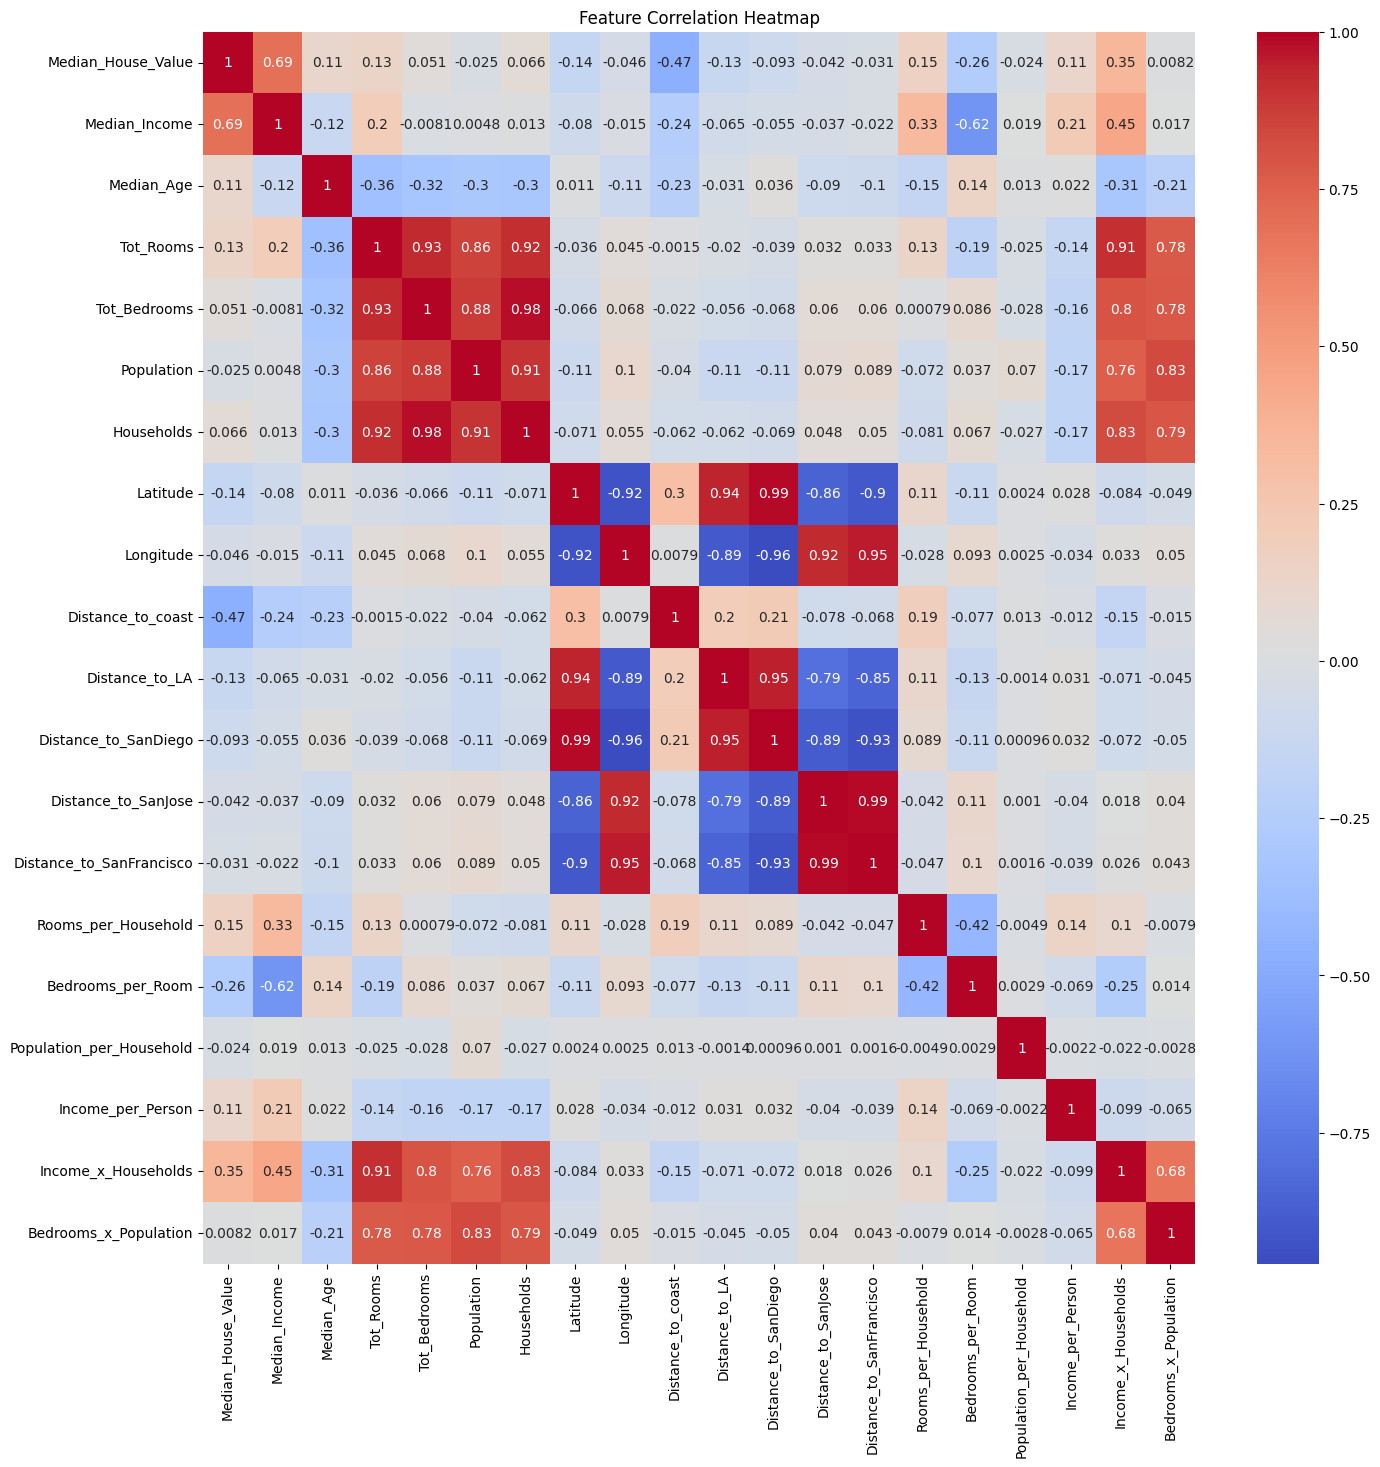

In [292]:
# Plotting correlation heatmap
plt.figure(figsize=(16, 16))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

array([[<Axes: xlabel='Median_House_Value', ylabel='Median_House_Value'>,
        <Axes: xlabel='Median_Income', ylabel='Median_House_Value'>,
        <Axes: xlabel='Income_x_Households', ylabel='Median_House_Value'>,
        <Axes: xlabel='Rooms_per_Household', ylabel='Median_House_Value'>,
        <Axes: xlabel='Bedrooms_per_Room', ylabel='Median_House_Value'>,
        <Axes: xlabel='Distance_to_coast', ylabel='Median_House_Value'>],
       [<Axes: xlabel='Median_House_Value', ylabel='Median_Income'>,
        <Axes: xlabel='Median_Income', ylabel='Median_Income'>,
        <Axes: xlabel='Income_x_Households', ylabel='Median_Income'>,
        <Axes: xlabel='Rooms_per_Household', ylabel='Median_Income'>,
        <Axes: xlabel='Bedrooms_per_Room', ylabel='Median_Income'>,
        <Axes: xlabel='Distance_to_coast', ylabel='Median_Income'>],
       [<Axes: xlabel='Median_House_Value', ylabel='Income_x_Households'>,
        <Axes: xlabel='Median_Income', ylabel='Income_x_Households'>,
     

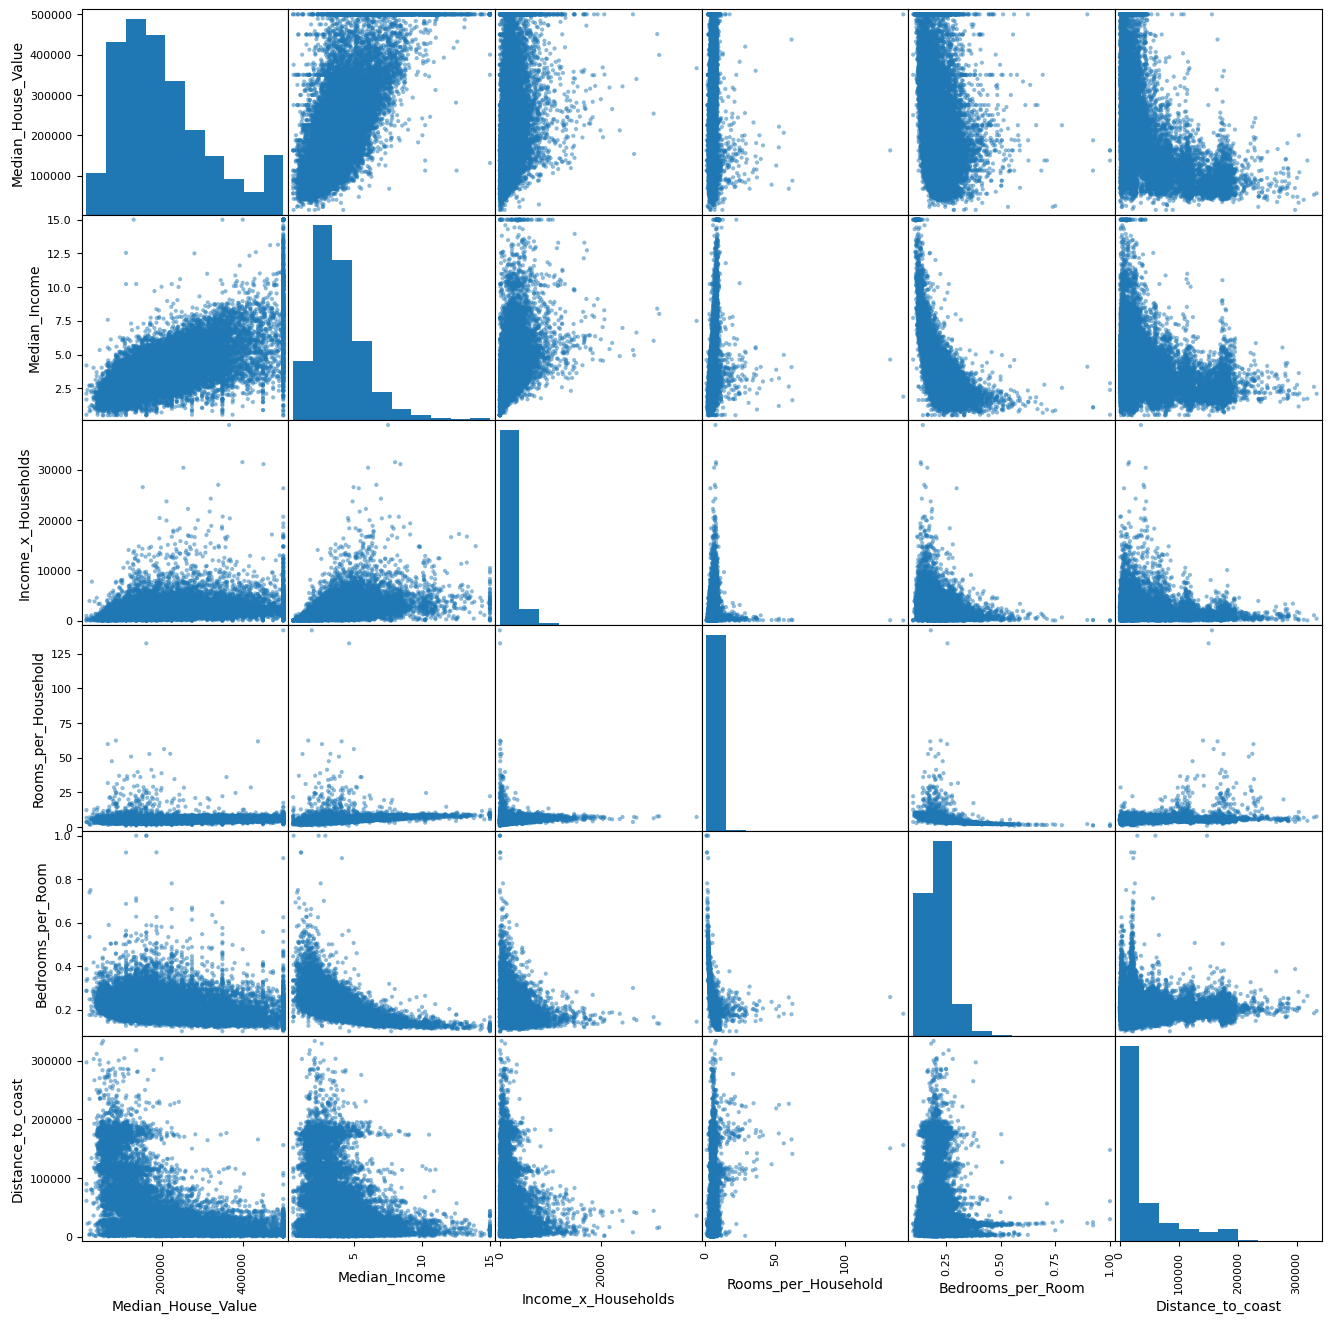

In [293]:
# Scatter matrix plot for selected important attributes
attributes = ["Median_House_Value", "Median_Income", "Income_x_Households", "Rooms_per_Household", "Bedrooms_per_Room", "Distance_to_coast"]
scatter_matrix(data[attributes], figsize=(16, 16))

<Axes: xlabel='Median_Income', ylabel='Median_House_Value'>

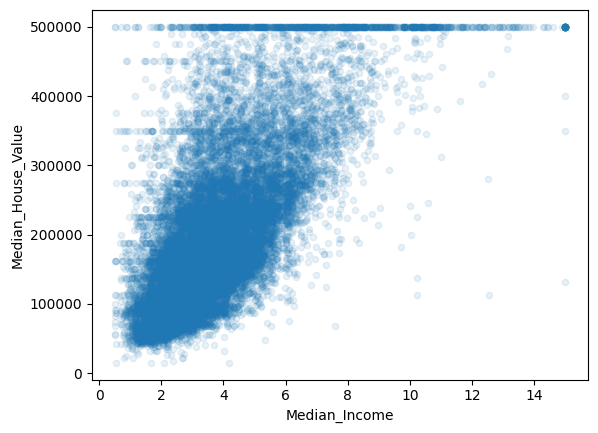

In [294]:
# Scatter plot to visualize relationship between Median Income and House Value
data.plot(kind="scatter", x="Median_Income", y="Median_House_Value", alpha=0.1)

In [295]:
# Remove outliers from the data
data = data[((data["Median_House_Value"] < 500000) & (data["Median_House_Value"] > 450200)) | 
             ((data["Median_House_Value"] < 449800) & (data["Median_House_Value"] > 350200)) | 
             (data["Median_House_Value"] < 349800)]

<Axes: xlabel='Median_Income', ylabel='Median_House_Value'>

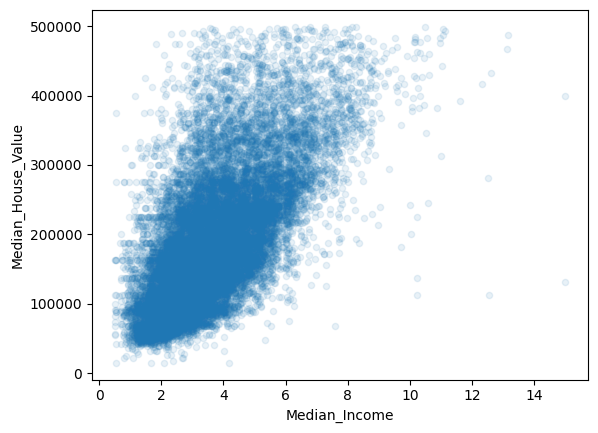

In [296]:
# Scatter plot again after outlier removal
data.plot(kind="scatter", x="Median_Income", y="Median_House_Value", alpha=0.1)

In [297]:
# Check shape after removing outliers
data.shape

(19529, 20)

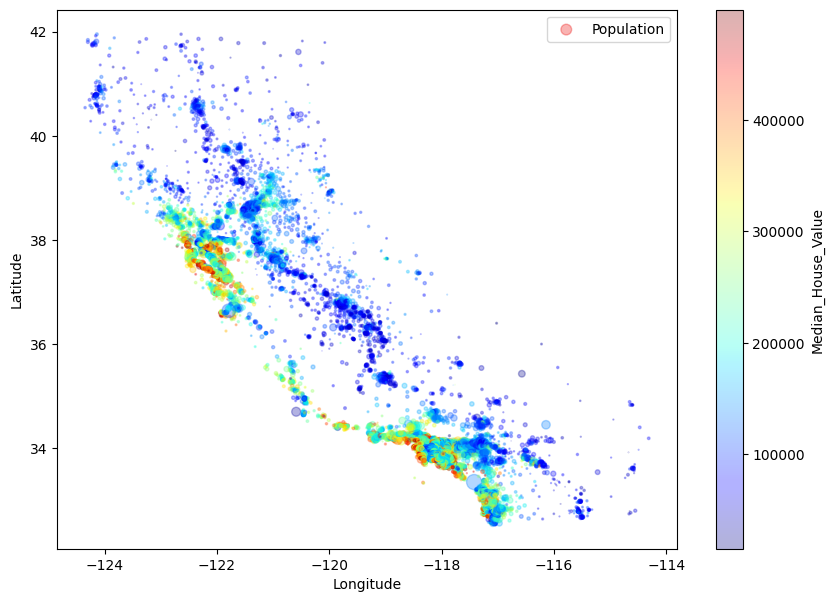

In [298]:
# Visualize geographic data with Population and House Values
data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.3,
          s=data["Population"]/300, label="Population", figsize=(10, 7),
          c="Median_House_Value", cmap="jet", colorbar=True)
plt.legend()
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_12232\988663166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Income_Cat"] = pd.cut(data["Median_Income"], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])


<Axes: >

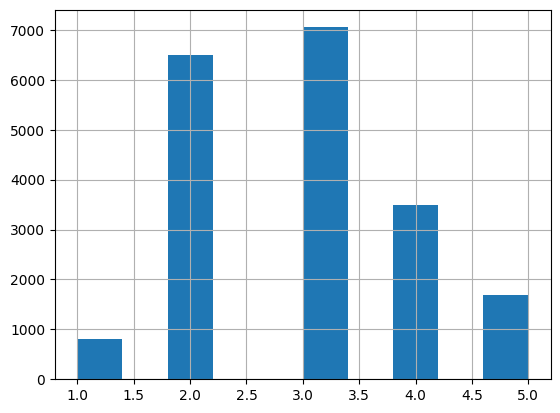

In [299]:
# Create income categories for stratified sampling
data["Income_Cat"] = pd.cut(data["Median_Income"], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
data["Income_Cat"].hist()

In [300]:
# Check datatype of Income_Cat
data["Income_Cat"].dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True, categories_dtype=int64)

In [301]:
# Perform stratified shuffle split to create train and test datasets
stratifiedSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratifiedSplit.split(data, data["Income_Cat"]):
    data_train = data.iloc[train_index]
    data_test = data.iloc[test_index]


In [302]:
# Check the distribution of income categories in train and test sets
data_test["Income_Cat"].value_counts() / len(data_test), data_train["Income_Cat"].value_counts() / len(data_train)

(Income_Cat
 3    0.361239
 2    0.333077
 4    0.178443
 5    0.086278
 1    0.040963
 Name: count, dtype: float64,
 Income_Cat
 3    0.361134
 2    0.333163
 4    0.178391
 5    0.086347
 1    0.040965
 Name: count, dtype: float64)

In [303]:
# Separate features and labels
y_train, y_test = data_train["Median_House_Value"], data_test["Median_House_Value"]
X_train, X_test = data_train.drop(columns=["Median_House_Value"]), data_test.drop(columns=["Median_House_Value"])

In [304]:
# Prepare preprocessing pipelines for numerical and categorical features
X_train['Income_Cat'] = X_train['Income_Cat'].astype('object')
X_test['Income_Cat'] = X_test['Income_Cat'].astype('object')

numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ["int64", "float64"]]
low_cardinality_cols = [col for col in X_train.columns if X_train[col].nunique() < 10 and X_train[col].dtype in ["object", "category"]]

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('std_Scaler', MinMaxScaler())
])

column_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), low_cardinality_cols)
])


In [305]:
# Initialize the XGBoost regressor
model = XGBRegressor(random_state=42)

In [306]:
# Fit and transform training data, transform test data
X_train_transformed = column_pipeline.fit_transform(X_train)
X_test_transformed = column_pipeline.transform(X_test)

In [307]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 500, 1000, 5000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.2, 0.4, 0.6],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_transformed, y_train)
print(random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 5000, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}


In [308]:
# Predict on the test set using the best estimator
y_pred = random_search.predict(X_test_transformed)

# Evaluate model using MAPE and MAE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

MAPE: 0.1405 (14.05%)
MAE: 23703.2657


In [309]:
# Save the best model to a file
joblib.dump(random_search, "cal_housing_model_V0.pkl")

['cal_housing_model_V0.pkl']

<Figure size 1000x800 with 0 Axes>

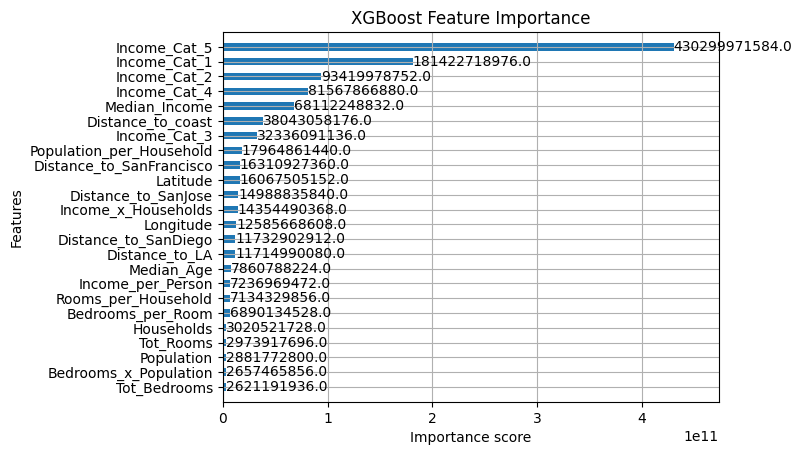

In [310]:
# Extract the final model
final_model = random_search.best_estimator_

# Get feature names after OneHotEncoding
ohe = column_pipeline.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(low_cardinality_cols)

# Combine numerical + categorical (one-hot) feature names
all_feature_names = list(numerical_cols) + list(ohe_feature_names)

# Set feature names inside XGBoost booster (important for plotting)
final_model.get_booster().feature_names = all_feature_names

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(final_model, importance_type='gain', height=0.5)
plt.title("XGBoost Feature Importance")
plt.show()

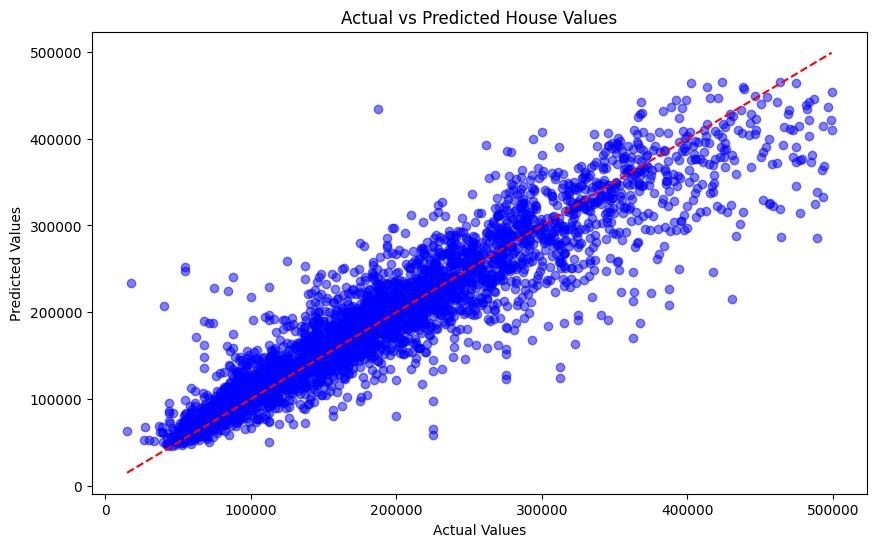

In [311]:
# Plot actual vs predicted values to visualize model performance
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Actual vs Predicted House Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()